This project is an exercise in leveraging features from text using a dataset previously harvested for the purpose of predicting Academy Awards nominations and wins.<br>
Specifically, it includes:<br>
- clustering of movies to assess what groupings the ML algorithm would find based on movie descriptions (`summary`);
- multi-label classification of movies by genre (where each movie can represent more than one genre), using first movie titles (`primaryTitle`) and then - movie summaries.

## 1. Imports and data setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('stopwords')
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import k_means, DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import silhouette_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import warnings

In [2]:
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [3]:
all_movies = pd.read_csv('./post-dsi/NLP_movie-topics/movies_data.csv', low_memory= False, index_col='tconst')
all_summaries = all_movies[all_movies['summary'].notna()]['summary']

In [4]:
all_movies.shape[0]

183485

## 2. Clustering of movies into "like" groupings

After transforming summaries into numerical data, I then use three types of clustering algorithms to group movies and see which performs best:<br>
- centroid-based K-Neighbors algorithm,
- density-based DBSCAN,
- hierarchical agglomerative clustering.

### 2.1. Transforming data through bag-of-n-grams vectorization

Because the entire dataset is large, for computational efficiency, I will perform clustering on a subset including only 10% of all movies:

In [5]:
sample_summaries = all_summaries.sample(frac = 0.1)

First, the summaries are transformed into a bag of n-grams, and each movie is represented as a vector with counts of the n-grams that are part of its summary.

In [6]:
cv = CountVectorizer(stop_words = 'english', ngram_range=(1,3), max_df = 0.99, min_df = 0.001, analyzer = 'word', token_pattern= '[a-zA-Z]+')

data = cv.fit_transform(sample_summaries)
data = data.todense()
data.shape

(14425, 2854)

The five rows below represent such vectors for the corresponding movies:

In [7]:
data_df = pd.DataFrame(data, columns = list(cv.vocabulary_.keys()), index = sample_summaries.index)
data_df.head()

,late,young,man,early,s,heads,victim,apartment,order,revenge,...,south africa,abused,williams,meant,big city,fighters,talking,love affair,strike,executive
tconst,,,,,,,,,,,,,,,,,,,,,
tt0765455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4630462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt3682618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt3874418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0109575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before clustering, the vector values are standardized using the Standard Scaler transformer:

In [8]:
stan = StandardScaler()
sample_data_sc = stan.fit_transform(data)

sample_data = pd.DataFrame(sample_data_sc, columns = data_df.columns, index = data_df.index)
sample_data.head()

,late,young,man,early,s,heads,victim,apartment,order,revenge,...,south africa,abused,williams,meant,big city,fighters,talking,love affair,strike,executive
tconst,,,,,,,,,,,,,,,,,,,,,
tt0765455,-0.080989,-0.039083,-0.042493,-0.048682,-0.042493,-0.032264,-0.042493,-0.03435,-0.042493,-0.03435,...,-0.047152,-0.0652,-0.039962,-0.032264,-0.075146,-0.033323,-0.034637,-0.04445,-0.040014,-0.035525
tt4630462,-0.080989,-0.039083,-0.042493,-0.048682,-0.042493,-0.032264,-0.042493,-0.03435,-0.042493,-0.03435,...,-0.047152,-0.0652,-0.039962,-0.032264,-0.075146,-0.033323,-0.034637,-0.04445,-0.040014,-0.035525
tt3682618,-0.080989,-0.039083,-0.042493,-0.048682,-0.042493,-0.032264,-0.042493,-0.03435,-0.042493,-0.03435,...,-0.047152,-0.0652,-0.039962,-0.032264,-0.075146,-0.033323,-0.034637,-0.04445,-0.040014,-0.035525
tt3874418,-0.080989,-0.039083,-0.042493,-0.048682,-0.042493,-0.032264,-0.042493,-0.03435,-0.042493,-0.03435,...,-0.047152,-0.0652,-0.039962,-0.032264,-0.075146,-0.033323,-0.034637,-0.04445,-0.040014,-0.035525
tt0109575,-0.080989,-0.039083,-0.042493,-0.048682,-0.042493,-0.032264,-0.042493,-0.03435,-0.042493,-0.03435,...,-0.047152,-0.0652,-0.039962,-0.032264,-0.075146,-0.033323,-0.034637,-0.04445,-0.040014,-0.035525


### 2.2. Centroid-based clustering (KMeans)

#### 2.2.1. Determining the right k

Because I am looking for unknown patterns and do not have a ready hypothesis as far as the "ideal" number of clusters the algorithm should attempt to find, I first search for the right value of k using the intertia scores calculated for k's between 10 and 200 (with a step of 10, to improve speed of processing) and the elbow method:

In [9]:
random_ks = np.random.choice(range(10,int(sample_data.shape[0]/3)), size = 50, replace = False)

In [10]:
inertia = {} # empty dictionary to store the calculated value of inertia for each tested value of k:
for k in random_ks: # assessing KMeans clustering with randomly selected values for k
    kmeans = KMeans(n_clusters= k) # initiating and fitting a K-means model with k clusters
    kmeans.fit(sample_data)
    inertia[k] = kmeans.inertia_ # assigning the key and value to the dictionary

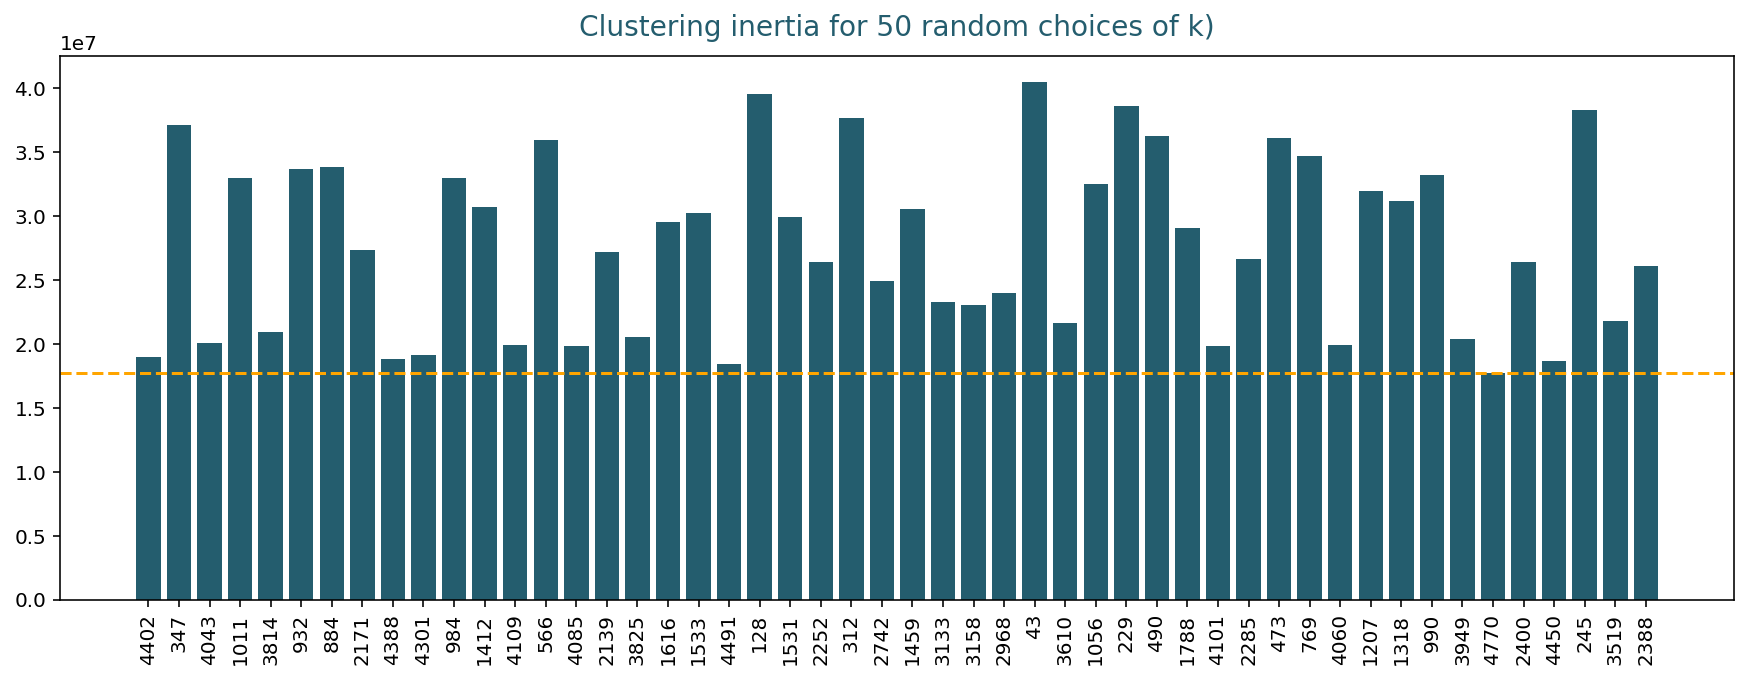

In [11]:
plt.figure(figsize = (15,5))
plt.bar(range(50), list(inertia.values()), color = '#245D6E')
plt.xticks(range(50), list(inertia.keys()), rotation = 90)
plt.title('Clustering inertia for 50 random choices of k)', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
plt.axhline(np.min(list(inertia.values())), ls = '--', color = 'orange')
plt.savefig('./post-dsi/NLP_movie-topics/random_ks.png', pad_inches = 0.2)

Calculating the silhouette score for the number of clusters with lowest inertia:

In [61]:
km_4770 = KMeans(n_clusters= 4770, n_init= 20, verbose= 0)
km_4770.fit(sample_data)

silhouette_score(sample_data, km_4770.predict(sample_data))

-0.05532091183024134

Checking for trade-off between lower count of clusters and silhouette score:

In [62]:
km_1000 = KMeans(n_clusters= 1000, n_init= 20, verbose= 0)
km_1000.fit(sample_data)

silhouette_score(sample_data, km_1000.predict(sample_data))

-0.07446831479773097

In [63]:
km_100 = KMeans(n_clusters= 100, n_init= 20, verbose= 0)
km_100.fit(sample_data)

silhouette_score(sample_data, km_100.predict(sample_data))

-0.002576648751639477

In [64]:
preds = km_100.predict(sample_data)

In [65]:
counts_by_cluster = {}
for cluster in range(0,100):
    counts_by_cluster[cluster] = sum([1 for pred in preds if pred == cluster])

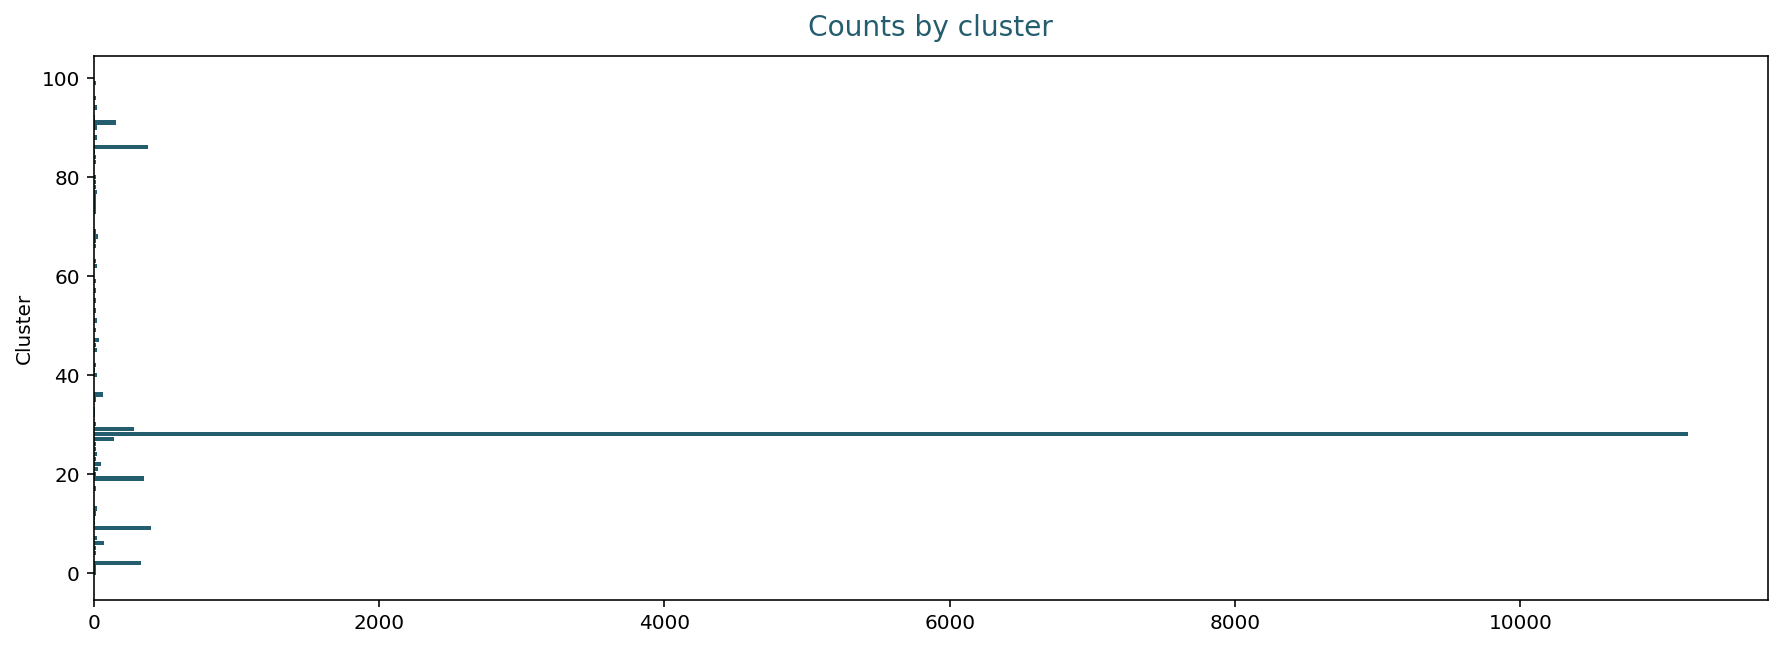

In [66]:
plt.figure(figsize = (15,5))
plt.barh(y = list(counts_by_cluster.keys()), width = list(counts_by_cluster.values()), color = '#245D6E', height = 0.9)
plt.title('Counts by cluster',fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
plt.ylabel('Cluster');

In [70]:
counts_by_cluster[28]/sample_data.shape[0]

0.7746967071057193

In [71]:
sample_data['km100_cluster'] = km_100.predict(sample_data)

In [72]:
def show_cluster(num_cluster, n_movies, column):
    size = min(n_movies, sample_data[sample_data[column]==num_cluster].shape[0])
    subset = sample_data[sample_data[column]==num_cluster].sample(size).index
    return all_movies.loc[subset,'summary']

In [80]:
pd.set_option('display.max_colwidth', 0)

show_cluster(28,10, 'km100_cluster')

tconst
tt0325655    A blind girl gets a cornea transplant so that she would be able to see again. However, she got more than what she bargained for when she realized she could even see ghosts.                                                       
tt0485388    Investigates the operations of the EnCana Corporation, a firm that, despite proud public declarations of its social responsibility, is shown to be answerable for widespread environmental contamination and human rights violation
tt4312522    Jeremy Brooks is an ambitious professional seeking to hit it big in the television news-business and become a leading anchor. During his journey, Jeremy lets his personal life, and bouts ...                                     
tt1213649    Jeff is a failing post-college writer whose parents are finally kicking him out of the house. With this in mind, Jeff starts out on a road trip to Austin, TX with his friend, Tom; a final ...                                    
tt0210567    Mona sacrifices 

Cluster # 28 has almost half of the movies in the streamlined dataset - presumably, these movies are difficult to group with others based on their descriptions. I want to test this by calculating the silhouette score for all remaining movies/clusters:

In [75]:
sample_data_subset = sample_data[sample_data['km100_cluster']!=28]

In [77]:
silhouette_score(sample_data[sample_data['km100_cluster']!=28].iloc[:,:-1], sample_data[sample_data['km100_cluster']!=28]['km100_cluster'])

0.0416621026583573

The silhouette score after removing the large heterogeneous cluster did not improve significantly - maybe re-clustering the movies which did not fall inside #23 will help:

In [78]:
km_subset = KMeans(n_clusters=100)
km_subset.fit(sample_data_subset)
silhouette_score(sample_data_subset, km_subset.predict(sample_data_subset))

-0.02084425312796652

It seems like it might take a different algorithm, or a more curated dataset to achieve better results. Before I try different algorithms, take a look at some randomly picked clusters:

In [81]:
show_cluster(np.random.randint(0,100), 10, 'km100_cluster')

tconst
tt2800052     A story of a love triangle. Richard is a young diplomat stationed on the south Asian island nation of Sri Lanka, who got married to a local girl. However due to his involvement at work, his...                                               
tt0156788     Melissa follows her dream of becoming a dancer all the way to New York City. But reality soon crushes her dreams forcing her to become a stripper to make ends meet. The seedy world of sex and drugs leads her into a dangerous love triangle.
tt11569822    Three school friends are stuck in a love triangle until a misunderstanding helps clear a lot of air.                                                                                                                                           
tt2428544     This Guy's in Love with U, Mare! is about an unlikely love triangle. When Lester (Vice Ganda) catches his boyfriend Mike (Luis Manzano) proposing marriage to Gemma (Toni Gonzaga), it seems ...                         

Based on a review of several random samples, the algorithm put together movies which share some words or expressions less common among other movies (e.g. "reunion", "hip-hop", "based on a true story", or "love triangle").

#### 2.3. Density-based clustering (DBSCAN)

Since the centroid-based K-Means algorithm had some trouble grouping movies into meaningful clusters, maybe the density-based DBSCAN can do better?

In [82]:
db = DBSCAN()
db.fit(sample_data.iloc[:,:-1])

sample_data['db_cluster'] = db.labels_
sample_data['db_cluster'].value_counts()

-1    14412
 0    13   
Name: db_cluster, dtype: int64

In [84]:
silhouette_score(sample_data.iloc[:,:-1], sample_data['db_cluster'])

-0.3232388865253408

Evidently, the examined features offer no groupings of movies that demonstrate relative density worth clustering together - almost all movies are determined to be outliers.

#### 2.4. Agglomerative Clustering

In [85]:
agg = AgglomerativeClustering(n_clusters = 100)

agg.fit(sample_data.iloc[:,:-2])

sample_data['agg_cluster'] = agg.labels_
#sample_data['agg_cluster'].value_counts()

In [86]:
silhouette_score(sample_data.iloc[:,:-2], sample_data['agg_cluster'])

0.0585463619213117

In [87]:
sample_data['agg_cluster'].value_counts()

6     11497
15    240  
20    218  
0     190  
10    159  
     ...   
49    12   
70    12   
83    11   
66    11   
50    1    
Name: agg_cluster, Length: 100, dtype: int64

Similar to K-Means, agglomerative clustering returned one massive cluster and a number of smaller ones. The overall silhouette score is not at all encouraging but unlike the K-Means results, there are no groupings of 1 or 2 movies, so let's take a look at some samples:

In [88]:
show_cluster(np.random.randint(2,100), 10, 'agg_cluster')

tconst
tt0118755    A secret family of four-inch people living inside the walls of a house must save their home from an evil real estate developer.                                                                                    
tt4145324    The daughter of a wealthy real estate broker falls in love with a younger man, who introduces her to B&D and S&M. Using her newly awakened sexual prowess, she finally takes charge of her own life.               
tt0461653    Jeremy Northam portrays a real estate tycoon, while Fionnula Flanagan plays the matriarch of the Lazarov family, in this psychological thriller.                                                                   
tt6247228    Brian walks through his childhood neighborhood, looking for new areas for real estate development. Romeo, in his glassy office, develops a marketing strategy. Carla plans her new ...                             
tt1826627    Young real estate agent Clara Morales encouraged risky loans to her clients duri

It seems like the smaller clusters are fairly coherent, and perhaps built on a more meaningful relationship than the occurrence of a single word, which was often the case for the K-Means-derived groupings.

### 2.4. Visualizing results using PCA

In [89]:
pca = PCA(n_components=2)
pcmps = pca.fit_transform(sample_data.iloc[:,:-2])
sample_data['pc1'] = pcmps[:,0]
sample_data['pc2'] = pcmps[:,1]

In [90]:
def plot_five_clusters(column, cluster1, cluster2, cluster3, cluster4, cluster5):
    subset = sample_data[sample_data[column].isin([cluster1, cluster2, cluster3, cluster4, cluster5])]
    subset['color'] = subset[column].map({cluster1: '#264653', cluster2: '#2a9d8f', cluster3: '#e9c46a', cluster4: '#f4a261', cluster5: '#e76f51'})
    #plt.figure(figsize = (10,10))
    method = {}
    method['km100_cluster'] = 'KMeans'
    method['agg_cluster'] = 'Agglomerative'
    plt.title(f"Clusters #{cluster1}, {cluster2}, {cluster3}, {cluster4}, and {cluster5} \nfrom {method[column]} clustering", fontdict = {"color": '#245D6E', 'fontsize': 15, 'fontweight': 'bold'}, pad = 10)
    plt.scatter(subset['pc1'], subset['pc2'], c=subset['color'], alpha = 0.8)
    plt.xlabel('Principal Component #1', fontdict = {'fontsize': 12})
    plt.ylabel('Principal Component #2', fontdict = {'fontsize': 12})
    #plt.savefig('./post-dsi/NLP_movie-topics/vis_clusters.png', pad_inches = 0.2)
    #plt.show()

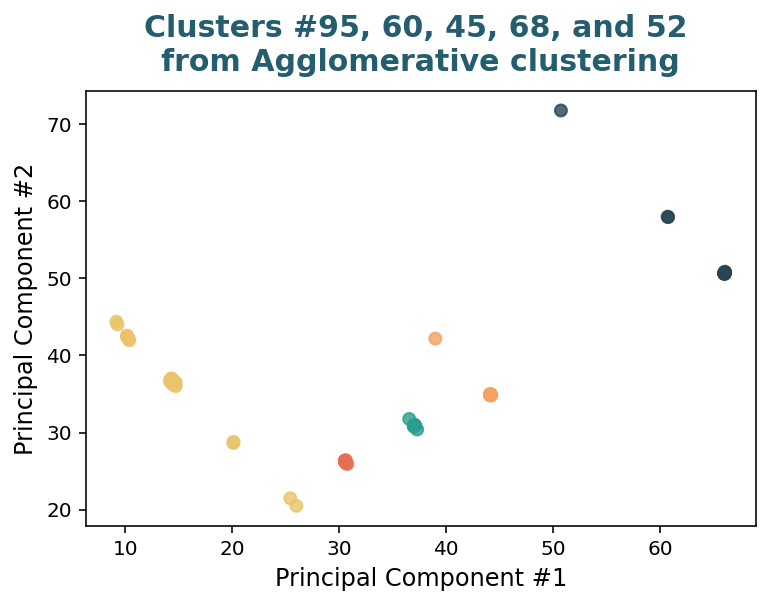

In [98]:
plot_five_clusters('agg_cluster', np.random.randint(0,100), np.random.randint(0,100), np.random.randint(0,100), np.random.randint(0,100), np.random.randint(0,100))

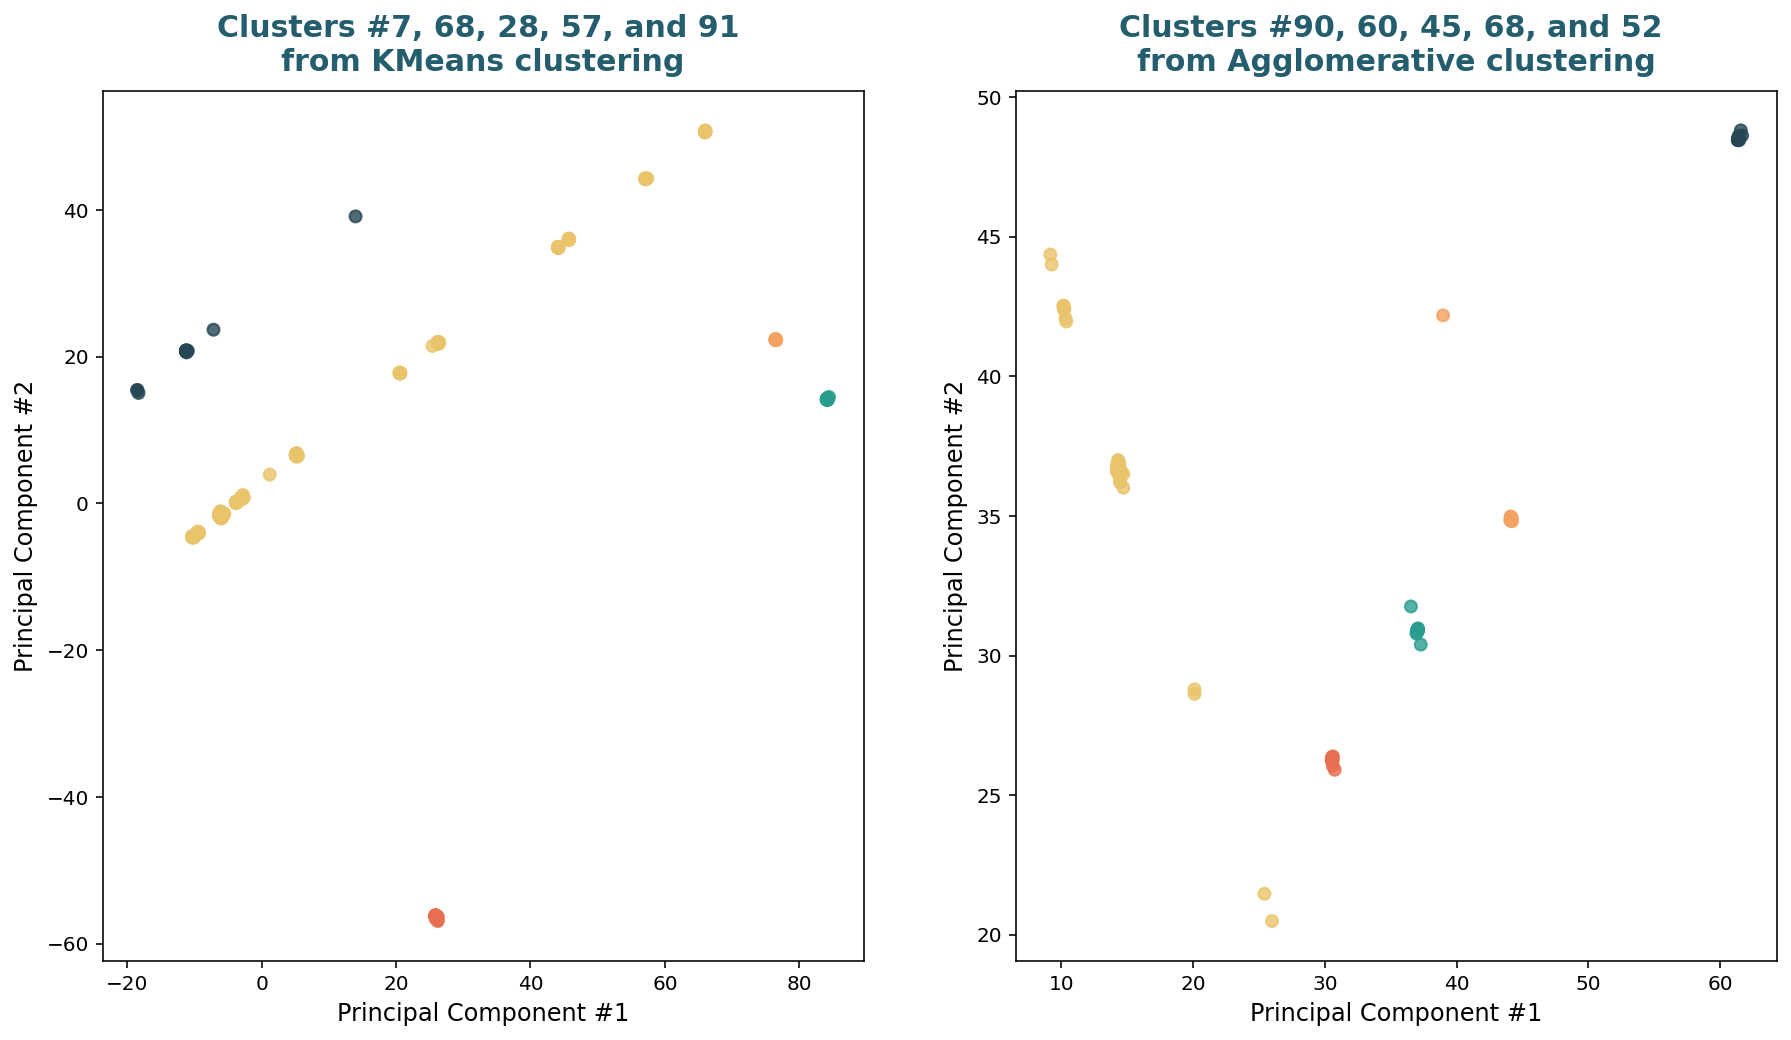

In [99]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plot_five_clusters('km100_cluster', 7, 68, 28, 57, 91)
plt.subplot(1,2,2)
plot_five_clusters('agg_cluster', 90, 60, 45, 68, 52);
plt.savefig('./post-dsi/NLP_movie-topics/KM_vs_Agg.png')

### 3.1. Creating labels for multi-output classification

In order to perform **multi-output classification** (multiple genres represented, plus each movie can represent multiple genres), I will first create binary labels and streamlight the large dataset to only represent most popular genres.

In [5]:
unique_genres = []
for entry in all_movies['genres']:
    if entry.find(",") > 0:
        split_entry = entry.split(",")
        for genre in split_entry:
            unique_genres.append(genre)

unique_genres = list(set(unique_genres))        

In [6]:
print(f"The dataset contains labels for {len(unique_genres)} unique genres: {unique_genres}.")

The dataset contains labels for 25 unique genres: ['War', 'Action', 'Biography', 'Western', 'History', 'Mystery', 'News', 'Family', 'Adventure', 'Sport', 'Music', 'Comedy', 'Adult', 'Horror', 'Musical', 'Documentary', 'Reality-TV', 'Sci-Fi', 'Crime', 'Romance', 'Thriller', 'Talk-Show', 'Animation', 'Drama', 'Fantasy'].


In [7]:
genre_counts = []
for genre in unique_genres:
    count_genre = 0
    for movie_genres in all_movies['genres']:
        if genre in movie_genres:
            count_genre +=1 
#    print(f"{genre} occurs {count_genre} times.")
    genre_counts.append(count_genre)
    
genre_counts_df = pd.DataFrame({'genre': unique_genres, 'count': genre_counts})
genre_counts_df.sort_values(['count'], ascending = False, inplace = True)

In [8]:
genre_counts_df['cum_perc'] = np.cumsum(list(genre_counts_df['count']))/genre_counts_df['count'].sum()

In [9]:
genre_counts_df['rank'] = genre_counts_df['cum_perc'].rank()
genre_counts_df

,genre,count,cum_perc,rank
23,Drama,75226,0.249406,1.0
15,Documentary,45197,0.399253,2.0
11,Comedy,39363,0.529758,3.0
1,Action,16761,0.585327,4.0
20,Thriller,16677,0.640619,5.0
19,Romance,16547,0.695479,6.0
13,Horror,13618,0.740628,7.0
18,Crime,12207,0.781099,8.0
8,Adventure,8415,0.808999,9.0
2,Biography,7838,0.834985,10.0


- The top ten genres by count represent 83% of the observations - when classifying, I will use this subset of data
- To filter the dataset, I will remove all movies whose `genres` value include genres below the cutoff ("Family" and below)

In [10]:
top10_genres = list(genre_counts_df[genre_counts_df['rank']<=10]['genre'])

In [11]:
for genre in top10_genres:
    all_movies[genre] = all_movies['genres'].apply(lambda x: 1 if x.find(genre) >= 0 else 0)

In [12]:
all_movies.sample(3)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,Horror,Crime,Adventure,Biography
tconst,,,,,,,,,,,,,,
tt10924440,Suckers,"When their school gets overrun with vampires, ...",Horror,88 min,0,0,0,0,0,0,1,0,0,0
tt1016256,Video X: The Dwayne and Darla-Jean Story,"VIDEO X: THE DWAYNE AND DARLA-JEAN STORY, this...",Thriller,NaN,0,0,0,0,1,0,0,0,0,0
tt13275496,Khushi Khushiyagi,Raj (Ganesh) is portrayed as a carefree guy wh...,Drama,151 min,1,0,0,0,0,0,0,0,0,0


In [13]:
all_movies['keep'] =  all_movies[top10_genres].apply(lambda x: sum(x), axis = 1)
genre_sel_movies = all_movies[all_movies['keep']>0].drop('keep', axis = 1)

In [14]:
genre_sel_movies.dropna(subset = ['primaryTitle','summary'], inplace = True)

In [15]:
genre_sel_movies.sample(3)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,Horror,Crime,Adventure,Biography
tconst,,,,,,,,,,,,,,
tt1053857,For a Fistful of Diamonds,"Once upon a time, a briefcase full of diamonds...",Action,NaN,0,0,0,1,0,0,0,0,0,0
tt0120142,The Sixth Man,A college athlete returns from the dead to hel...,"Comedy,Drama,Fantasy",107 min,1,0,1,0,0,0,0,0,0,0
tt4159576,Jaywalker,"At the age of nine, jaywalking became a realit...","Documentary,Drama",83 min,1,1,0,0,0,0,0,0,0,0


### 3.2. Classifying movies by genre using `primaryTitle`

#### 3.2.1. Setting up feaures from text

In [16]:
train_all, test_all = train_test_split(genre_sel_movies, test_size = 0.1, stratify = genre_sel_movies['Drama'])

In [17]:
print(f"The training set includes {train_all.shape[0]} titles and the test set has {test_all.shape[0]} movies")

The training set includes 124105 titles and the test set has 13790 movies


In [18]:
cvec = CountVectorizer(stop_words = 'english', ngram_range=(1,3), max_df = 0.99, min_df = 0.001, analyzer = 'word', token_pattern= '[a-zA-Z]+')
title_train_features = cvec.fit_transform(train_all['primaryTitle'])
stan = StandardScaler()
title_train_features_sc = stan.fit_transform(title_train_features.todense())
title_train_features_df = pd.DataFrame(data = title_train_features_sc, columns = cvec.get_feature_names(), index = train_all.index)
title_train_features_df.head()

,al,america,american,angel,angels,art,away,b,baby,bad,...,woman,women,world,x,y,year,years,young,zero,zombie
tconst,,,,,,,,,,,,,,,,,,,,,
tt0117189,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt12764238,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt3060224,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt0113578,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt5961516,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507


In [19]:
title_test_features = cvec.transform(test_all['primaryTitle'])
title_test_features_sc = stan.transform(title_test_features.todense())
title_test_features_df = pd.DataFrame(data = title_test_features_sc, columns = cvec.get_feature_names(), index = test_all.index)
title_test_features_df.head()

,al,america,american,angel,angels,art,away,b,baby,bad,...,woman,women,world,x,y,year,years,young,zero,zombie
tconst,,,,,,,,,,,,,,,,,,,,,
tt2580486,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt2290597,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt0270980,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt2714900,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507
tt0446755,-0.032744,-0.04907,-0.066537,-0.039157,-0.036156,-0.045824,-0.032634,-0.041104,-0.035556,-0.047897,...,-0.045466,-0.044203,-0.07373,-0.036718,-0.041854,-0.041859,-0.040377,-0.039157,-0.032881,-0.032507


In [20]:
print(f"Both the training set and the test set represent {title_train_features_df.shape[1]} features.")

Both the training set and the test set represent 234 features.


In [21]:
train_labels = train_all[top10_genres]
test_labels = test_all[top10_genres]

#### 3.2.2. Setting up, training, and evaluating the classifier:

In [22]:
from sklearn.multioutput import MultiOutputClassifier
moc = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = 10))
moc.fit(title_train_features_df, train_labels)

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=10))

In [23]:
moc.score(title_test_features_df, test_labels)

0.04169688179840464

In [24]:
preds = moc.predict(title_test_features_df)

In [25]:
preds_df = pd.DataFrame(data = preds, columns = ["pred_"+genre for genre in top10_genres], index = test_all.index)
preds_df.head()

,pred_Drama,pred_Documentary,pred_Comedy,pred_Action,pred_Thriller,pred_Romance,pred_Horror,pred_Crime,pred_Adventure,pred_Biography
tconst,,,,,,,,,,
tt2580486,0,0,0,0,0,0,0,0,0,0
tt2290597,0,0,0,0,0,0,0,0,0,0
tt0270980,1,0,0,0,0,0,0,0,0,0
tt2714900,0,1,0,0,0,0,0,0,0,0
tt0446755,0,0,0,0,0,0,0,0,0,0


In [26]:
test_all = test_all.merge(preds_df, left_index = True, right_index = True)
test_all.sample(5)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,...,pred_Drama,pred_Documentary,pred_Comedy,pred_Action,pred_Thriller,pred_Romance,pred_Horror,pred_Crime,pred_Adventure,pred_Biography
tconst,,,,,,,,,,,,,,,,,,,,,
tt5377624,Kingdom of Gladiators: The Tournament,A Templar Knight is forced to fight as a gladi...,"Action,Drama,Fantasy",87 min,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0341555,Sex Is Zero,At a South Korean university most students are...,"Comedy,Romance",96 min,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
tt6522634,The Lost Brother,"Cetarti, a public employee who has just been f...","Crime,Drama,Thriller",112 min,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
tt0374226,Small Mall,"A Eurovision singer, Icelands strongest woman,...","Comedy,Documentary,Reality-TV",NaN,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5465370,Naam Hai Akira,A gripping action thriller about a college gir...,"Action,Thriller",137 min,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


The two summaries below checks whether the classifier assigned more than genre label to any of the movies in the test dataset.<br>
First, I compute the number of movies in the test dataset which were labeled with 1, 2, or 3 distinct genres. The second summay lists the number of movies which were assigned 0-4 predicted labels.<br>
For ~3,700 movies, the classifier did not predict a label at all, however, it recognized that over ~1,500 movies belonged to more than one genre.

In [40]:
def check_results(data):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for genre in top10_genres:
        tp += data[(data[genre] == 1) & (data['pred_'+ genre]==1)].shape[0]
        tn += data[(data[genre] == 0) & (data['pred_'+ genre]==0)].shape[0]
        fp += data[(data[genre] == 0) & (data['pred_'+ genre]==1)].shape[0]
        fn += data[(data[genre] == 1) & (data['pred_'+ genre]==0)].shape[0]
    print(f"The calculated overall accuracy of the model is {round((tp+tn) / (tn+tp+fn+fp),4)}.")
    print(f"The calculated overall recall of the model is {round(tp / (tp+fp),4)}.")
    print(f"The calculated overall precision of the model is {round(tp / (tp+fn),4)}.")

In [41]:
check_results(test_all)

The calculated overall accuracy of the model is 0.8445.
The calculated overall recall of the model is 0.4843.
The calculated overall precision of the model is 0.0563.


In [27]:
test_all['real_labels'] = test_all.apply(lambda x: x[top10_genres].sum(), axis = 1)
test_all['real_labels'].value_counts()

1    7856
2    4292
3    1642
Name: real_labels, dtype: int64

In [28]:
test_all['pred_labels'] = test_all.apply(lambda x: x[[col for col in test_all.columns if col[:4] =='pred']].sum(), axis = 1)
test_all['pred_labels'].value_counts()

0    11396
1     2306
2       88
Name: pred_labels, dtype: int64

In [64]:
test_all.columns

Index(['primaryTitle', 'summary', 'genres', 'runtime', 'Drama', 'Documentary',
       'Comedy', 'Action', 'Thriller', 'Romance', 'Horror', 'Crime',
       'Adventure', 'Biography', 'pred_Drama', 'pred_Documentary',
       'pred_Comedy', 'pred_Action', 'pred_Thriller', 'pred_Romance',
       'pred_Horror', 'pred_Crime', 'pred_Adventure', 'pred_Biography',
       'real_labels', 'pred_labels', 'preds_Drama', 'preds_Documentary',
       'preds_Comedy', 'preds_Action', 'preds_Thriller', 'preds_Romance',
       'preds_Horror', 'preds_Crime', 'preds_Adventure', 'preds_Biography',
       'preds_labels'],
      dtype='object')

In [66]:
totals_comp_t = pd.DataFrame({'real': test_all[top10_genres].agg(np.sum),'predicted': test_all[preds_df.columns].agg(np.sum)}).reset_index()
totals_comp_t['genre'] = totals_comp_t['index'].apply(lambda x: x if x[:4]!= 'pred' else x[5:])
totals_comp_t = totals_comp_t.pivot_table(index = 'genre')

for genre in top10_genres:
    totals_comp_t.loc[genre,"tp_t"]=test_all[(test_all[genre]==1) & test_all["pred_"+genre]==1].shape[0]
    totals_comp_t.loc[genre,"tn_t"]=test_all[(test_all[genre]==0) & test_all["pred_"+genre]==0].shape[0]
    totals_comp_t.loc[genre,"fp_t"]=test_all[(test_all[genre]==0) & test_all["pred_"+genre]==1].shape[0]
    totals_comp_t.loc[genre,"fn_t"]=test_all[(test_all[genre]==1) & test_all["pred_"+genre]==0].shape[0]
    
totals_comp_t['accuracy_t'] = (totals_comp_t['tp_t'] + totals_comp_t['tn_t'])/(totals_comp_t['tp_t'] + totals_comp_t['tn_t'] + totals_comp_t['fp_t'] + totals_comp_t['fn_t'])
totals_comp_t['recall_t'] = totals_comp_t['tp_t']/(totals_comp_t['tp_t'] + totals_comp_t['fp_t'])
totals_comp_t['precision_t'] = totals_comp_t['tp_t']/(totals_comp_t['tp_t'] + totals_comp_t['fn_t'])

In [67]:
totals_comp_t['train_real'] = train_all[totals_comp_t.index].sum()
totals_comp_t.sort_values('real', ascending = False)

,predicted,real,tp_t,tn_t,fp_t,fn_t,accuracy_t,recall_t,precision_t,train_real
genre,,,,,,,,,,
Drama,1551.0,6344.0,758.0,12997.0,793.0,13032.0,0.498731,0.488717,0.054967,57090
Documentary,482.0,3488.0,242.0,13550.0,240.0,13548.0,0.500073,0.502075,0.017549,31066
Comedy,226.0,3424.0,101.0,13665.0,125.0,13689.0,0.499130,0.446903,0.007324,30456
Thriller,19.0,1475.0,5.0,13776.0,14.0,13785.0,0.499674,0.263158,0.000363,13659
Romance,8.0,1421.0,4.0,13786.0,4.0,13786.0,0.500000,0.500000,0.000290,12987
Action,41.0,1412.0,17.0,13766.0,24.0,13773.0,0.499746,0.414634,0.001233,12710
Horror,152.0,1228.0,74.0,13712.0,78.0,13716.0,0.499855,0.486842,0.005366,10997
Crime,2.0,1056.0,0.0,13788.0,2.0,13790.0,0.499927,0.000000,0.000000,9798
Adventure,1.0,778.0,1.0,13790.0,0.0,13789.0,0.500036,1.000000,0.000073,6918


In [33]:
(totals_comp['tp_t'].sum()+totals_comp['tn_t'].sum())/(totals_comp['tp_t'].sum()+totals_comp['tn_t'].sum() + totals_comp['fp_t'].sum()+totals_comp['fn_t'].sum())

0.4997171863669326

In [38]:
def see_sample(genre, tp_fn_fp_tn, n):
    if tp_fn_fp_tn == 'tp':
        sample = test_all[(test_all[genre] == 1) & (test_all['pred_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'tn':
        sample = test_all[(test_all[genre] == 0) & (test_all['pred_'+genre] == 0)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fp':
        sample = test_all[(test_all[genre] == 0) & (test_all['pred_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fn':
        sample = test_all[(test_all[genre] == 1) & (test_all['pred_'+genre] == 0)].sample(n).iloc[:,:4]
    return sample

In [39]:
see_sample('Romance', 'fn', 3)

,primaryTitle,summary,genres,runtime
tconst,,,,
tt10551450,Twivortiare,A man and woman fell in love and immediately g...,"Drama,Romance",103 min
tt3230920,Os Maias: Cenas da Vida Romântica,"The tragedy and comedy in Carlo's life begins,...","Drama,Romance",139 min
tt6798892,White December,White December is an Australian LGBTI Independ...,"Drama,Romance",76 min


Clearly (and understandably), predicting genres from only the title of a movie was problematic for the algorithm. Next, I'm going to see if the performance improves when instead of just the title, the estimator uses features from the movies' descriptive summaries.

### 3.3. Classifying movies by genre using `summary`

#### 3.3.1. Setting up feaures from text

In [42]:
print(f"The training set includes {train_all.shape[0]} titles and the test set has {test_all.shape[0]} movies")

The training set includes 124105 titles and the test set has 13790 movies


In [43]:
cvecs = CountVectorizer(stop_words = 'english', ngram_range=(1,3), max_df = 0.99, min_df = 0.001, analyzer = 'word', token_pattern= '[a-zA-Z]+')
summ_train_features = cvecs.fit_transform(train_all['summary'])
stans = StandardScaler()
summ_train_features_sc = stans.fit_transform(summ_train_features.todense())
summ_train_features_df = pd.DataFrame(data = summ_train_features_sc, columns = cvecs.get_feature_names(), index = train_all.index)
summ_train_features_df.head()

,abandoned,abducted,ability,able,abroad,absence,abuse,abused,abusive,academy,...,young women,younger,younger brother,youngest,youngsters,youth,zealand,zombie,zombies,zone
tconst,,,,,,,,,,,,,,,,,,,,,
tt0117189,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt12764238,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt3060224,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt0113578,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt5961516,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873


In [44]:
summ_test_features = cvecs.transform(test_all['summary'])
summ_test_features_sc = stans.transform(summ_test_features.todense())
summ_test_features_df = pd.DataFrame(data = summ_test_features_sc, columns = cvecs.get_feature_names(), index = test_all.index)
summ_test_features_df.head()

,abandoned,abducted,ability,able,abroad,absence,abuse,abused,abusive,academy,...,young women,younger,younger brother,youngest,youngsters,youth,zealand,zombie,zombies,zone
tconst,,,,,,,,,,,,,,,,,,,,,
tt2580486,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt2290597,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt0270980,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt2714900,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873
tt0446755,-0.081509,-0.035706,-0.040593,-0.054012,-0.04166,-0.032397,-0.047792,-0.035827,-0.04584,-0.037762,...,-0.043278,-0.068066,-0.039484,-0.034322,-0.035018,-0.074211,-0.033441,-0.045528,-0.039066,-0.033873


In [45]:
print(f"Both the training set and the test set represent {summ_train_features_df.shape[1]} features.")

Both the training set and the test set represent 2767 features.


#### 3.3.2. Setting up, training, and evaluating the classifier:

In [46]:
mocs = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = 5))
mocs.fit(summ_train_features_df, train_labels)

MultiOutputClassifier(estimator=KNeighborsClassifier())

In [47]:
mocs.score(summ_test_features_df, test_labels)

0.1760696156635243

Not surprisingly, the average accuracy of the classifier trained on movie descriptions/summaries is much better than that trained only on titles.

In [48]:
predss = mocs.predict(summ_test_features_df)

In [49]:
predss_df = pd.DataFrame(data = predss, columns = ["preds_"+genre for genre in top10_genres], index = test_all.index)

predss_df.head()

,preds_Drama,preds_Documentary,preds_Comedy,preds_Action,preds_Thriller,preds_Romance,preds_Horror,preds_Crime,preds_Adventure,preds_Biography
tconst,,,,,,,,,,
tt2580486,0,1,0,0,0,0,0,0,0,1
tt2290597,1,0,0,0,0,0,0,0,0,0
tt0270980,1,0,0,0,0,0,0,0,0,0
tt2714900,0,1,0,0,0,0,0,0,0,0
tt0446755,0,0,0,0,0,0,0,0,0,0


In [50]:
test_all = test_all.merge(predss_df, left_index = True, right_index = True)
test_all.sample(5)

,primaryTitle,summary,genres,runtime,Drama,Documentary,Comedy,Action,Thriller,Romance,...,preds_Drama,preds_Documentary,preds_Comedy,preds_Action,preds_Thriller,preds_Romance,preds_Horror,preds_Crime,preds_Adventure,preds_Biography
tconst,,,,,,,,,,,,,,,,,,,,,
tt4329418,Flowers in the Shadows,Welcome to the first beauty contest dedicated ...,"Biography,Documentary",63 min,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt3243474,Bastards y Diablos,Two estranged half-brothers adventure together...,"Adventure,Drama",99 min,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
tt0387926,Whose Is This Song?,"The film is a funny, dramatic and tragicomic s...","Documentary,Music",NaN,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
tt11143486,The Last American Colony,"Puerto Rico, the last relic of colonization in...",Documentary,90 min,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0417499,Le bonheur c'est une chanson triste,"Imagine it is summer and that, for the last se...",Drama,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The two summaries below checks whether the classifier assigned more than genre label to any of the movies in the test dataset.<br>
First, I compute the number of movies in the test dataset which were labeled with 1, 2, or 3 distinct genres. The second summay lists the number of movies which were assigned 0-4 predicted labels.<br>
For ~3,700 movies, the classifier did not predict a label at all, however, it recognized that over ~1,500 movies belonged to more than one genre.

In [51]:
test_all['real_labels'] = test_all.apply(lambda x: x[top10_genres].sum(), axis = 1)
test_all['real_labels'].value_counts()

1    7856
2    4292
3    1642
Name: real_labels, dtype: int64

In [52]:
test_all['preds_labels'] = test_all.apply(lambda x: x[[col for col in test_all.columns if col[:4] =='pred']].sum(), axis = 1)
test_all['preds_labels'].value_counts()

1    7015
0    3060
2    1818
3    1558
4     267
5      65
6       5
7       2
Name: preds_labels, dtype: int64

In [53]:
totals_comp = pd.DataFrame({'real': test_all[top10_genres].agg(np.sum),'predicteds': test_all[predss_df.columns].agg(np.sum)}).reset_index()
totals_comp['genre'] = totals_comp['index'].apply(lambda x: x if x[:5]!= 'preds' else x[6:])
totals_comp = totals_comp.pivot_table(index = 'genre')

for genre in top10_genres:
    totals_comp.loc[genre,"tp"]=test_all[(test_all[genre]==1) & test_all["preds_"+genre]==1].shape[0]
    totals_comp.loc[genre,"tn"]=test_all[(test_all[genre]==0) & test_all["preds_"+genre]==0].shape[0]
    totals_comp.loc[genre,"fp"]=test_all[(test_all[genre]==0) & test_all["preds_"+genre]==1].shape[0]
    totals_comp.loc[genre,"fn"]=test_all[(test_all[genre]==1) & test_all["preds_"+genre]==0].shape[0]
    
totals_comp['accuracy'] = (totals_comp['tp'] + totals_comp['tn'])/(totals_comp['tp'] + totals_comp['tn'] + totals_comp['fp'] + totals_comp['fn'])
totals_comp['recall'] = totals_comp['tp']/(totals_comp['tp'] + totals_comp['fp'])
totals_comp['precision'] = totals_comp['tp']/(totals_comp['tp'] + totals_comp['fn'])

In [54]:
totals_comp['train_real'] = train_all[totals_comp.index].sum()
totals_comp.sort_values('real', ascending = False)

,predicteds,real,tp,tn,fp,fn,accuracy,recall,precision,train_real
genre,,,,,,,,,,
Drama,6137.0,6344.0,3266.0,10919.0,2871.0,10524.0,0.514322,0.532182,0.236838,57090
Documentary,2405.0,3488.0,1359.0,12744.0,1046.0,12431.0,0.511349,0.565073,0.098550,31066
Comedy,2006.0,3424.0,764.0,12548.0,1242.0,13026.0,0.482669,0.380857,0.055402,30456
Thriller,140.0,1475.0,40.0,13690.0,100.0,13750.0,0.497825,0.285714,0.002901,13659
Romance,358.0,1421.0,112.0,13544.0,246.0,13678.0,0.495141,0.312849,0.008122,12987
Action,220.0,1412.0,85.0,13655.0,135.0,13705.0,0.498187,0.386364,0.006164,12710
Horror,243.0,1228.0,143.0,13690.0,100.0,13647.0,0.501559,0.588477,0.010370,10997
Crime,125.0,1056.0,52.0,13717.0,73.0,13738.0,0.499239,0.416000,0.003771,9798
Adventure,45.0,778.0,10.0,13755.0,35.0,13780.0,0.499094,0.222222,0.000725,6918


In [55]:
def sees_sample(genre, tp_fn_fp_tn, n):
    if tp_fn_fp_tn == 'tp':
        sample = test_all[(test_all[genre] == 1) & (test_all['preds_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'tn':
        sample = test_all[(test_all[genre] == 0) & (test_all['preds_'+genre] == 0)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fp':
        sample = test_all[(test_all[genre] == 0) & (test_all['preds_'+genre] == 1)].sample(n).iloc[:,:4]
    if tp_fn_fp_tn == 'fn':
        sample = test_all[(test_all[genre] == 1) & (test_all['preds_'+genre] == 0)].sample(n).iloc[:,:4]
    return sample

In [56]:
sees_sample('Romance', 'fn', 3)

,primaryTitle,summary,genres,runtime
tconst,,,,
tt1282444,Minnaminnikkoottam,The story is about seven friends working in a ...,"Romance,Thriller",NaN
tt0168734,Un embrujo,"t in Mexico during the 30's, a young boy falls...","Drama,Romance",NaN
tt5751844,La Rancherita,A Tex Mex Singer does anything to save her kid...,"Comedy,Romance",81 min


In [58]:
genre_counts_df.head()

,genre,count,cum_perc,rank
23,Drama,75226,0.249406,1.0
15,Documentary,45197,0.399253,2.0
11,Comedy,39363,0.529758,3.0
1,Action,16761,0.585327,4.0
20,Thriller,16677,0.640619,5.0


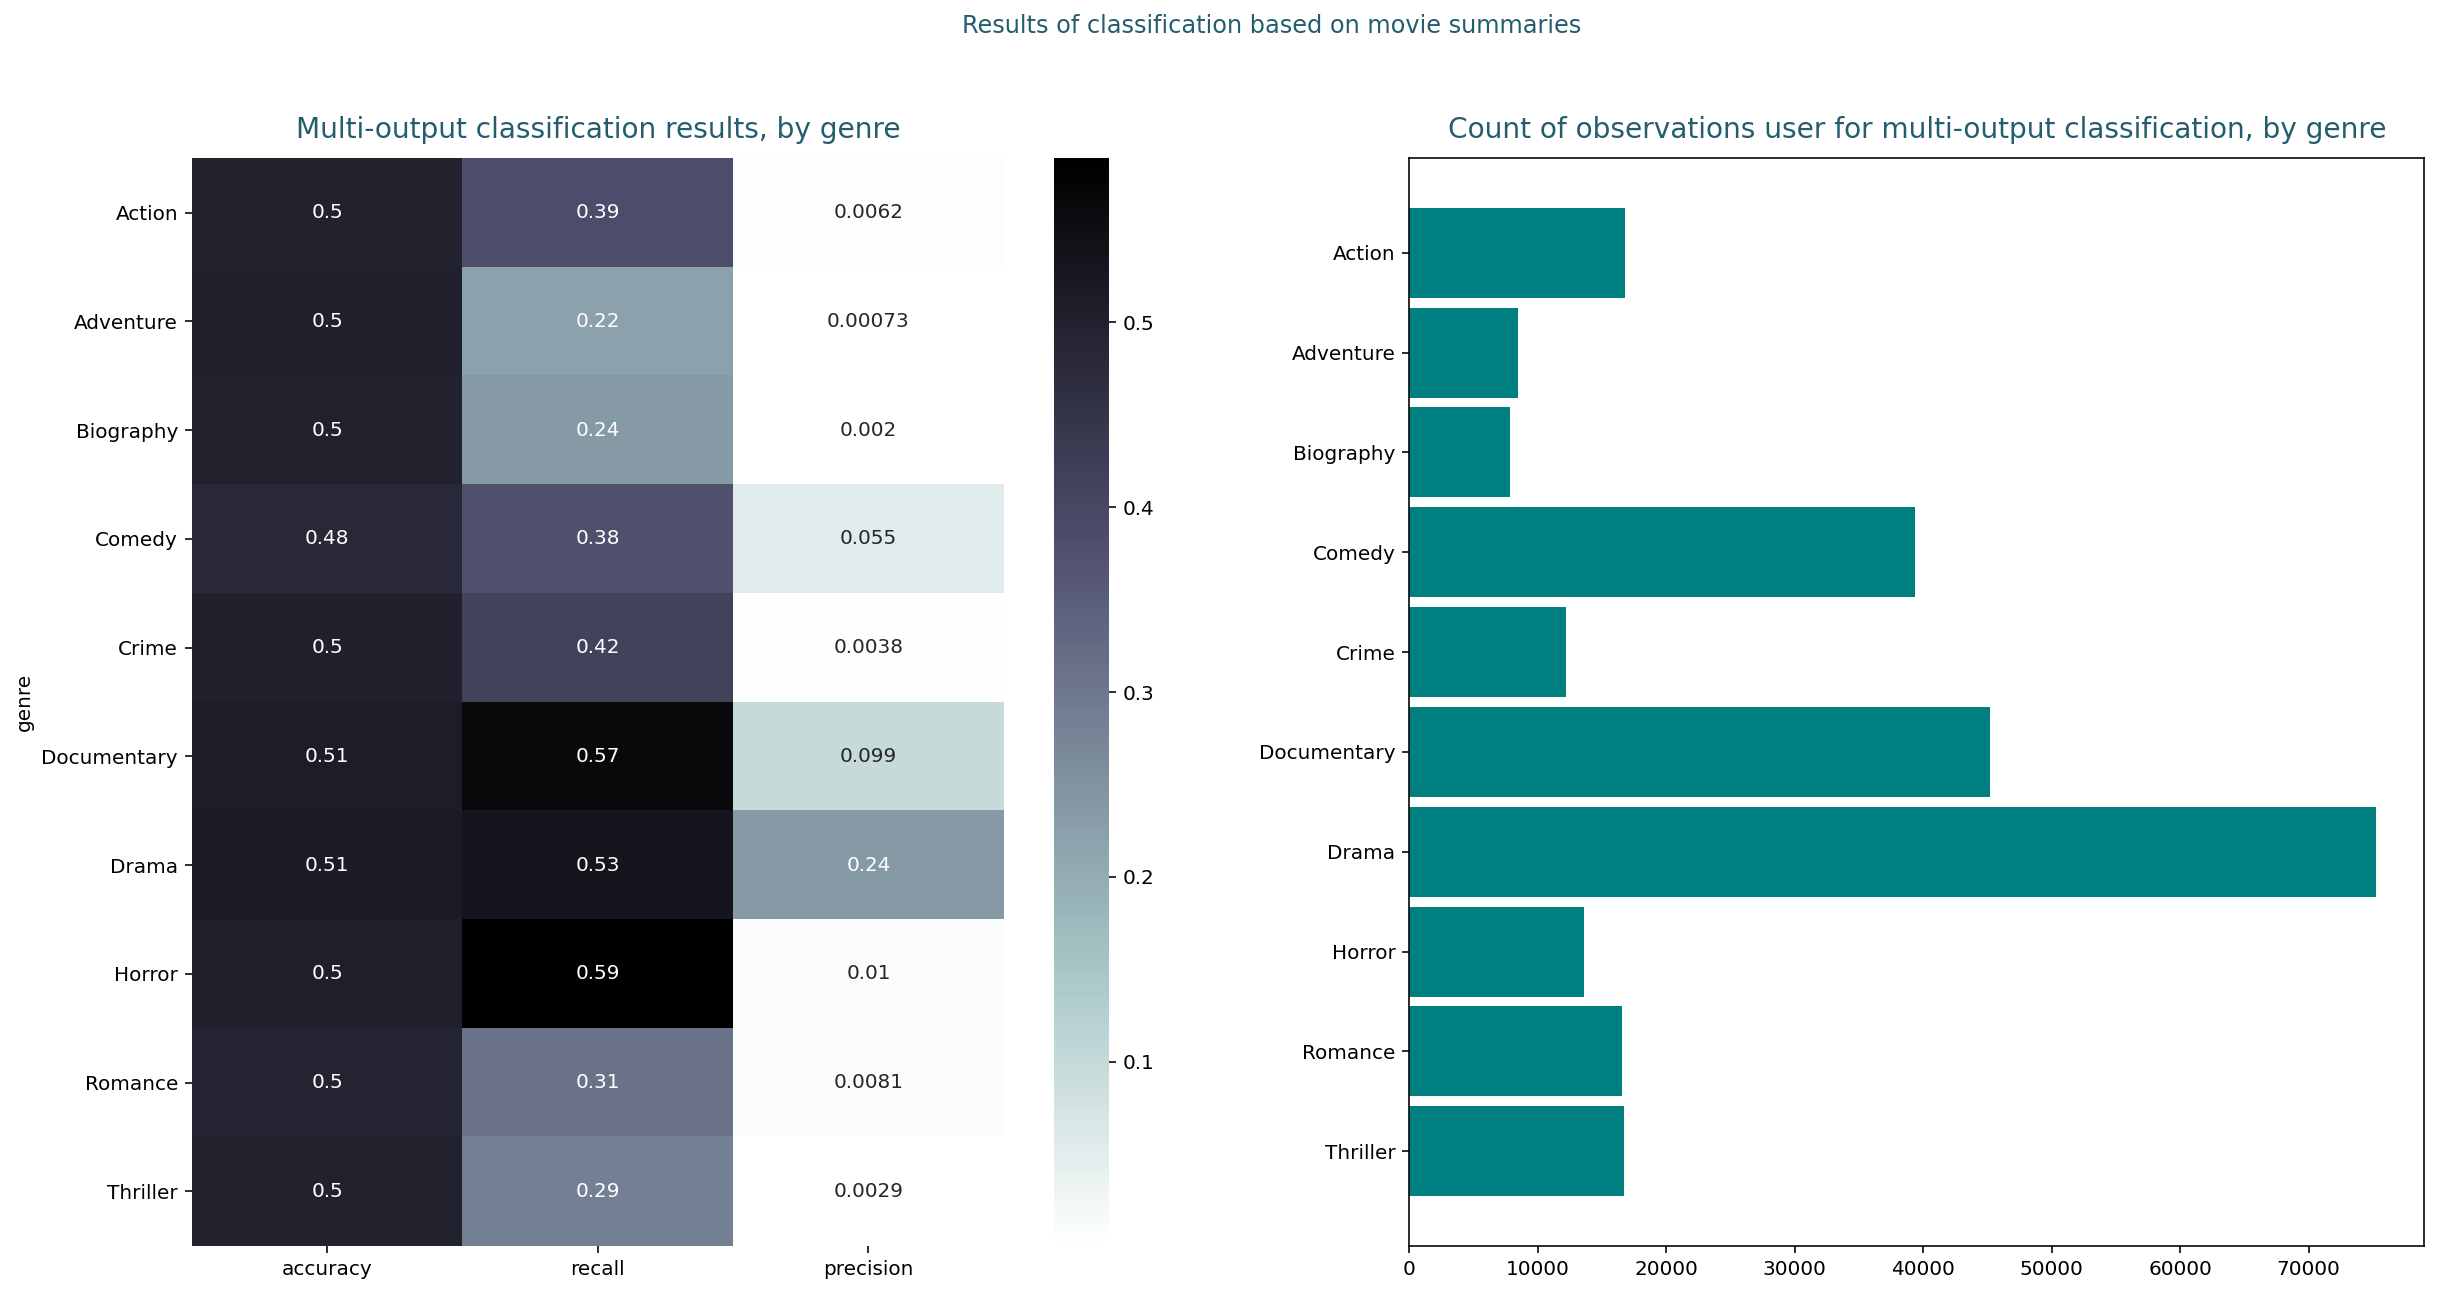

In [71]:
plt.figure(figsize = (20,10))
plt.suptitle('Results of classification based on movie summaries', fontdict = {"color": '#245D6E', 'fontsize': 16, 'fontweight': 7})
plt.subplot(1,2,1)
plt.title('Multi-output classification results, by genre', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
sns.heatmap(totals_comp[['accuracy', 'recall','precision']], cmap = 'bone_r', annot = True);
plt.subplot(1,2,2)
plt.title('Count of observations user for multi-output classification, by genre', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
plt.barh(genre_counts_df.iloc[:10,:].sort_values('genre', ascending = False)['genre'], genre_counts_df.iloc[:10,:].sort_values('genre', ascending = False)['count'], height = 0.9, color = 'teal')
plt.savefig('./post-dsi/NLP_movie-topics/moc_results_s.png', pad_inches = 0.2)

In [62]:
totals_comp.head()

,predicteds,real,tp,tn,fp,fn,accuracy,recall,precision,train_real
genre,,,,,,,,,,
Action,220.0,1412.0,85.0,13655.0,135.0,13705.0,0.498187,0.386364,0.006164,12710
Adventure,45.0,778.0,10.0,13755.0,35.0,13780.0,0.499094,0.222222,0.000725,6918
Biography,119.0,740.0,28.0,13699.0,91.0,13762.0,0.497716,0.235294,0.002030,6511
Comedy,2006.0,3424.0,764.0,12548.0,1242.0,13026.0,0.482669,0.380857,0.055402,30456
Crime,125.0,1056.0,52.0,13717.0,73.0,13738.0,0.499239,0.416000,0.003771,9798


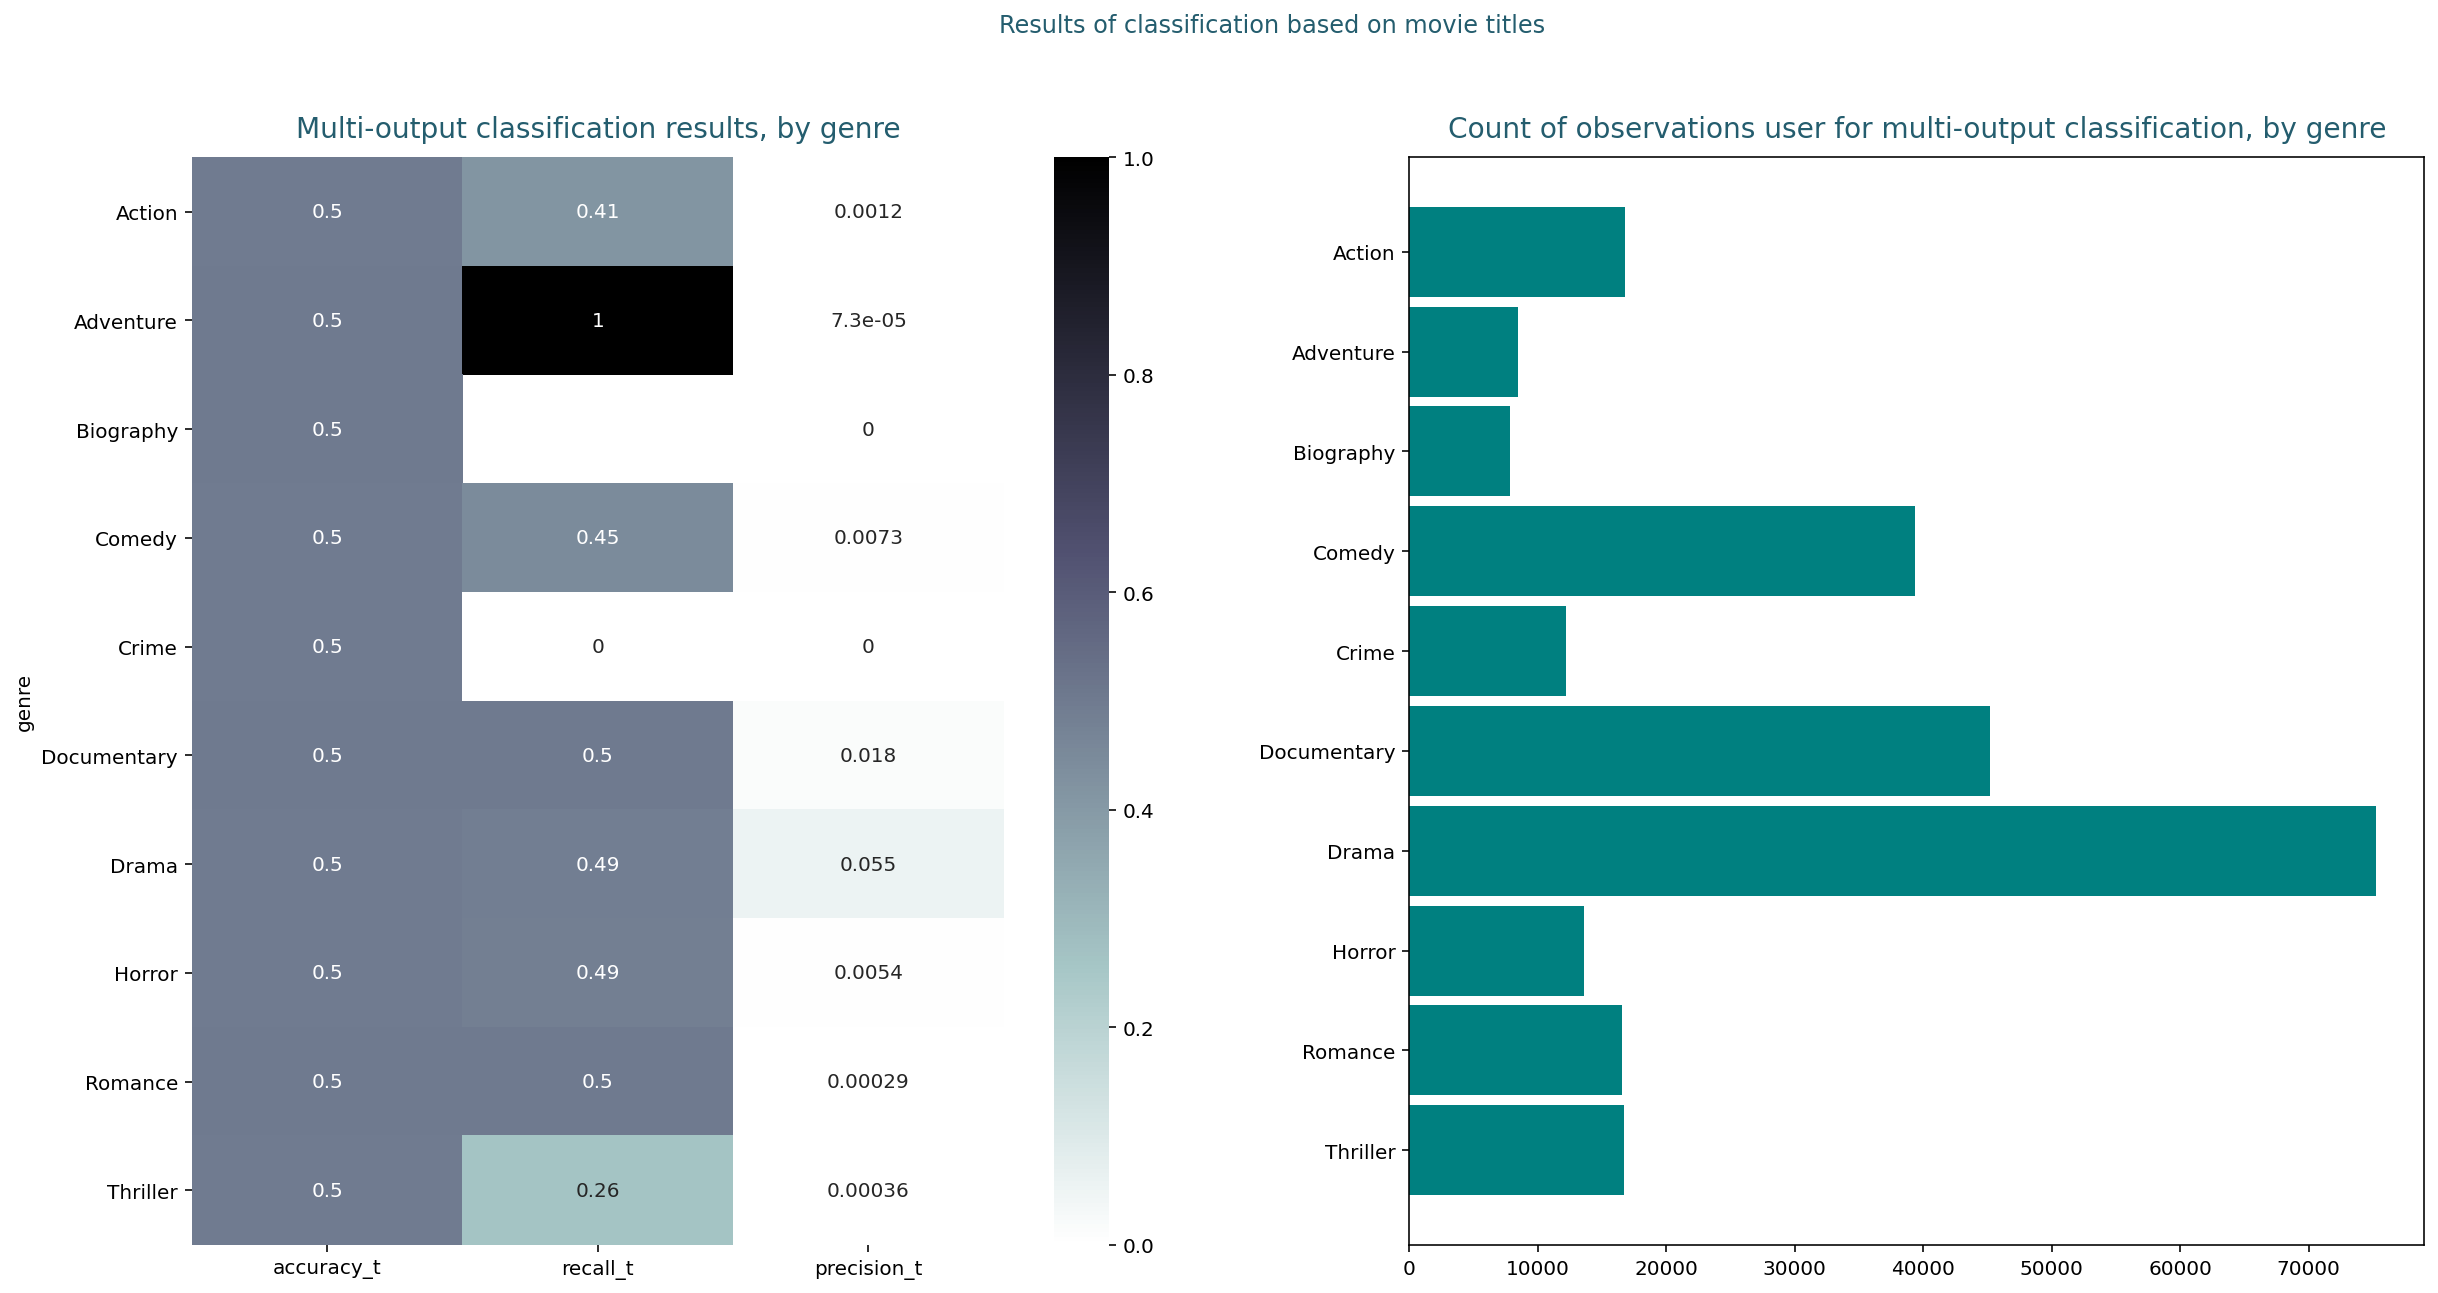

In [70]:
plt.figure(figsize = (20,10))
plt.suptitle('Results of classification based on movie titles', fontdict = {"color": '#245D6E', 'fontsize': 16, 'fontweight': 7})
plt.subplot(1,2,1)
plt.title('Multi-output classification results, by genre', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
sns.heatmap(totals_comp_t[['accuracy_t', 'recall_t','precision_t']], cmap = 'bone_r', annot = True);
plt.subplot(1,2,2)
plt.title('Count of observations user for multi-output classification, by genre', fontdict = {"color": '#245D6E', 'fontsize': 14, 'fontweight': 5}, pad = 10)
plt.barh(genre_counts_df.iloc[:10,:].sort_values('genre', ascending = False)['genre'], genre_counts_df.iloc[:10,:].sort_values('genre', ascending = False)['count'], height = 0.9, color = 'teal')
plt.savefig('./post-dsi/NLP_movie-topics/moc_results_t.png', pad_inches = 0.2)

### 4. Conclusions

Clustering of movies into logical groupings based just on the words featured on their summaries was challenging as far as achieving high scores. Density-based scanning failed to perform any clustering while K-Means and Agglomerative Clustering each returned one large grouping of movies with little in common, in addition to a number of more meaningful clusters. <br>
The multi-output classifier trained on features extracted from movie summaries performed better for genres with more than 30,000 observations in the training dataset. 
<br>
<br>
Future exploration might include:<br>
- tuning the hyperparameters of the word vectorizer (e.g. to account for longer phrases like 4-grams or 5-grams, to find better thresholds for trimming the vocabulary, or to apply the term frequency-inverse document frequency logic) and the multi-output classifier (e.g. by adjusting the number of neighbors),
- Training a neural network to more accurately perform the same multi-output classification task,
- Training a multi-output classifier with estimator objects other than KNC (e.g. Decision Tree),
- Using a combination of `summary` and `title` in predicting the genre,
- Training a binary classifier to only classify one genre at a time.